# Structure factor 
Simply comparing structure factor calculation from the following programs : 
shelxl, gemmi and blochwave.

In [28]:
from utils import*;imp.reload(dsp)
import io,os,pandas as pd,numpy as np
from subprocess import check_output
import misc_utils as mut;imp.reload(mut)
from EDutils import utilities as ut 
from scattering import scattering_factors as sf;imp.reload(sf)
from scattering import structure_factor as sF  ;imp.reload(sF)
from blochwave import bloch                    ;imp.reload(bloch)
from crystals import crystal
from multislice import mupy_utils as mupy;
import gemmi
cif_file='resources/LTA.cif'
figs = (10,5)
# dsp.matplotlib.use('agg')

## Miscleanious
### Importing the structure

LTA has chemical formula is $SiO_2$ and crystalllizes in space group [221](http://img.chem.ucl.ac.uk/sgp/LARGE/221az1.htm). 

In [17]:
## check the structure is properly read (as done in blochwave) 
crys = crystal.Crystal.from_cif(cif_file)
print('lat_params  : ',crys.lattice_parameters)
print('formula     : ',crys.chemical_formula)
print('space_group : ','\n  '.join( [''] + [ '%s : %s' %(k.ljust(20),str(v)) for k,v in crys.symmetry().items() ]))

lat_params  :  (11.9, 11.9, 11.9, 90.0, 90.0, 90.0)
formula     :  O2 Si
space_group :  
  international_symbol : Pm-3m
  hall_symbol          : -P 4 2 3
  hm_symbol            : Pm-3m
  centering            : CenteringType.primitive
  international_number : 221
  hall_number          : 517
  international_full   : P 4/m -3 2/m
  pointgroup           : m-3m


### Atoms in the unit cell
Space group 221 has 48 symmetry operations
Note that the number of symmetry operations 
For example if an atom has $z=0.5$ any pair of symmetry operations differing by $\bar z$ (such as $x,\bar y,z$ and $x,\bar y,\bar z$ ) applied to that atom would result in the same location. In space group 221 it is such that the total unique count for that atom is reduced by 2. 

In summary : 

- Silicon $Si_{001}$ Oxygen $O_{002}$ and $O_{003}$ have $z=0.5$  so each of these atoms have 24 replicas.
- $O_{002}$ has $x=1$ (lies on the faces of the unit cell). Any symmetry operations involving $\bar x$ would result in $x=0$ which would already be obtained by the translational symmetry of the crystal so the number of atoms of $O_{002}$ is divided by 2 hence 12.
- $O_{003}$ has $x=y$ which also further divide its unique count by 2 hence 12.
- $O_{004}$ has $y=\bar z$ which reduces its count from 48 to 24.
  
In the unit cell, there should be $24$ unique atoms of Silicon, $24+2\times 12=48$ atoms of oxygen.



1 | 2 | 3
-- | -- |--
![](figs/lta_a.png) | ![](figs/lta_2.png)  | ![](figs/lta_O.png) 

1) as seen along one of its axis
2) as seen in from the side
3) red, purple and orange show how oxygen atoms $O_{002}$,$O_{003}$,$O_{004}$ are transformed by the symmetry operators

In [33]:
pattern = np.array([np.hstack([a.coords_fractional,int(a.atomic_number)]) for a in crys.atoms])
print('n_silicon :',len(pattern[pattern[:,-1]==14]))
print('n_oxygen  :',len(pattern[pattern[:,-1]==8]))

n_silicon : 24
n_oxygen  : 48


Saving figure :
figs/lta_O.png


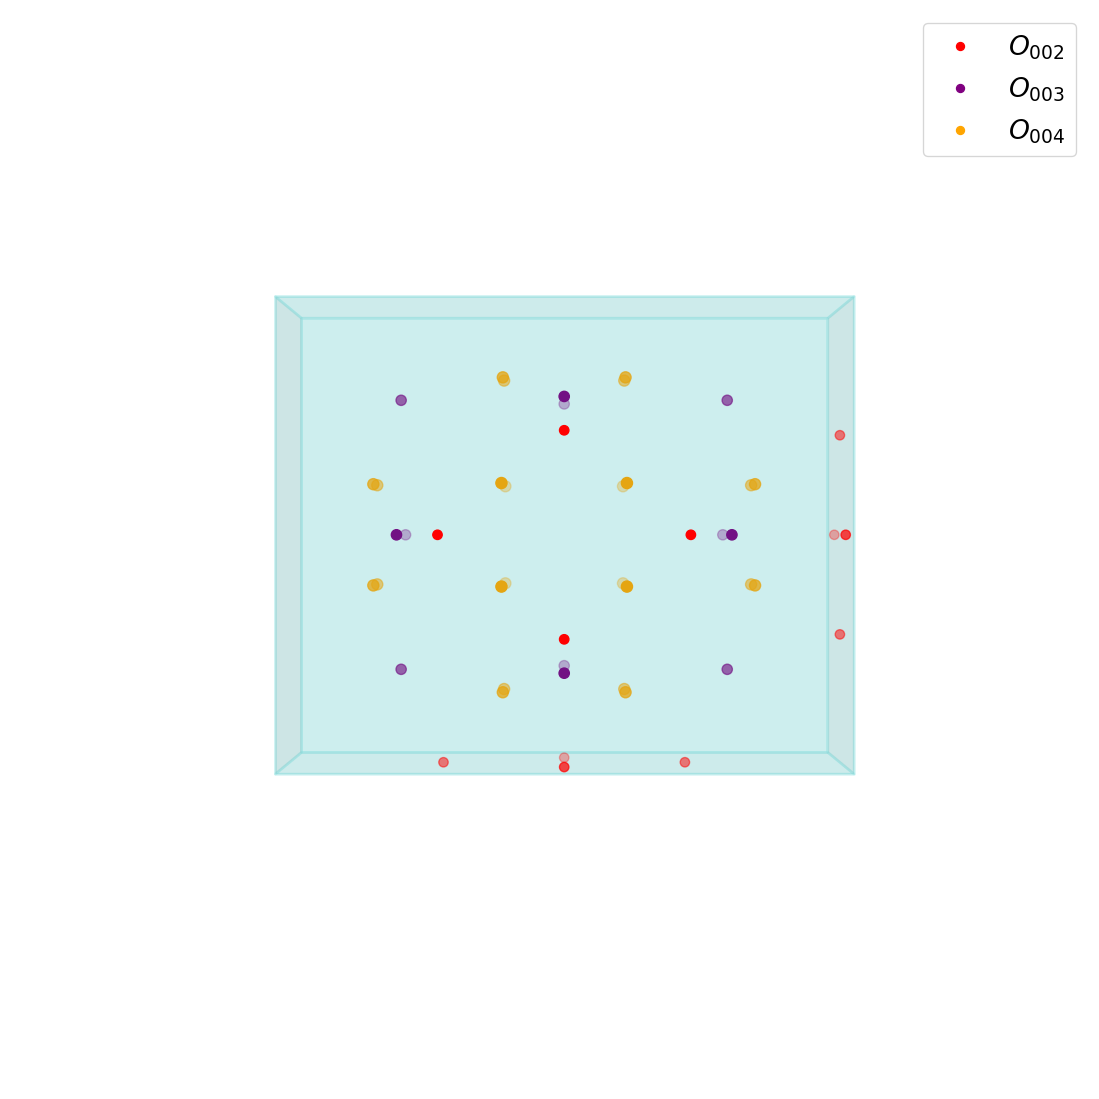

In [35]:
### Showing how each oxygen atom is transformed by the symmetry operators
Oxygens=pattern[pattern[:,-1]==8,:3]
x2,y2,z2 = Oxygens[ [any(x==0.0) for x in Oxygens]].T
x3,y3,z3 = Oxygens[ [any(x==0.5) and all(x>0) for x in Oxygens]].T
x4,y4,z4 = Oxygens[ [not any(x==0.5) and all(x>0) for x in Oxygens]].T

%matplotlib inline
ms=50
mesh=[x/crys.lattice_parameters[0] for x in crys.mesh(range(2),range(2),range(2))]
surfs = mupy.get_unit_cell(mesh, n=[0,0,1])


fig,ax = dsp.stddisp(axPos=[0,0,1,1],rc='3d',scat=[],surfs=surfs,
                     legElt={'$O_{002}$':['red','o'],'$O_{003}$':['purple','o'],'$O_{004}$':['orange','o']},
                     figsize=(5,5));
ax.scatter(x2,y2,z2,s=50,c='red');
ax.scatter(x3,y3,z3,s=60,c='purple');
ax.scatter(x4,y4,z4,s=70,c='orange');
ax.view_init(elev=0, azim=180);
ax.set_position([0,0,1,1]);
ax.axis('off');
# dsp.saveFig('figs/lta_O.png')

### Scattering factors

The scatttering factors are originally determined from the Born approximation [Kirkland2019](#Kirkland2019) : 

\begin{equation}
    f_e(q) = \frac{2\pi m_0e}{h^2}\int V_a(\mathbf r)e^{2i\pi\mathbf q\cdot\mathbf r}d^3r
\end{equation}

where $f_e$(in $A$) is the scattering factor, $m_0$ the electron rest mass, $e$ the elementary charge, $h$ is Plank's constant, $V_a$ is the atomic potential for each element and $\mathbf q$ is the transfer vector momentum.

[Shelxl](https://srv.mbi.ucla.edu/faes/) uses a fit with 4 gaussians (gemmi uses 5 gaussians): 
\begin{equation}
    f(s) = \sum_{j=1}^{4} a_j\exp\left(-b_js^2\right)
\end{equation}
where $s=\sin(\theta)/\lambda$ is the scattering parameter and $2\theta$ is the scattering angle. 

while Earl J. Kirkland uses a fit with 3 Lorentzian and 3 Gaussians : 
\begin{equation}
    f(q) = \sum_{i=1}^{3} \frac{a_i}{q^2+b_i} + c_i\exp\left(-d_iq^2\right)
\end{equation}
where $q=2\sin(\theta)/\lambda=2s$. 

Note that the convention for $q$ (and not $s$) represents the actual distances in reciprocal space(see struture factor below.

The fits are compared below. Note that at large values of $q>4^{-1}$, the fits seem to differ a little bit especially for silicon.


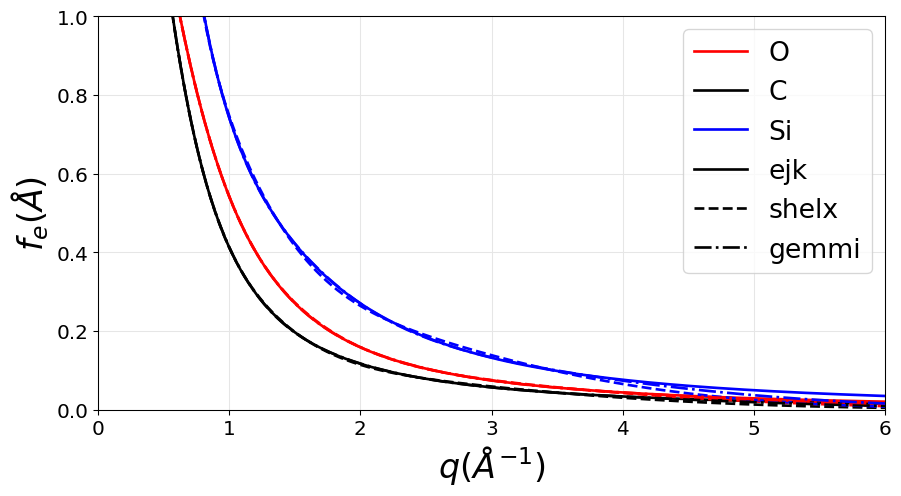

In [156]:
%matplotlib inline
q=np.linspace(0,6,1000)
fe_EJK = sf.get_fe(np.array([6,8,14]),q=q,fit='kirkland')
fe_SLX = sf.get_fe(np.array(['C','O','Si']),q=q,fit='shelxl')
fe_GEM = np.array([ np.array([gemmi.Element(elt).c4322.calculate_sf(s**2) for s in q/2]) for elt in ['C','O','Si']]).T

na = 3
legElt = {'O':'r','C':'k','Si':'b','ejk':'k-','shelx':'k--' ,'gemmi':'k-.'}
cs = [legElt[k] for k in ['C','O','Si']]

plts =[[q,fe_EJK[:,i],[cs[i],'-' ],''] for i in range(na)]
plts+=[[q,fe_SLX[:,i],[cs[i],'--'],''] for i in range(na)]
plts+=[[q,fe_GEM[:,i],[cs[i],'-.'],''] for i in range(na)]

dsp.stddisp(plts,figsize=figs,legElt=legElt,
    labs=[r'$q(\AA^{-1})$','$f_e(\AA)$'],
    lw=2,xylims=[0,6,0,1]);


### Computing structure factors 
The [structure factor](https://en.wikipedia.org/wiki/Structure_factor) exact formula is : 
\begin{equation}
    F(q) = \sum_j f_j^{(e)}(q)\exp(-2i\pi \mathbf q\cdot\mathbf r_j)
\end{equation}
where : 

- $j$ runs over the atoms in the unit cell, 

- $\mathbf{r_j} = x_j \mathbf a + y_j\mathbf b + z_j\mathbf c$ are the atomic coordinates. $(x_j,y_j,z_j)$ are known as the fractional coordinates and $(\mathbf a,\mathbf b,\mathbf c)$  is the real crystal basis.

- $\mathbf{q} = h \mathbf a^{\ast} + k\mathbf b^{\ast} + h\mathbf c^{\ast}$ is the scattering vector in reciprocal space of reflection $(h,k,l)$ where $(\mathbf a^{\ast},\mathbf b^{\ast},\mathbf c^{\ast})$ is the reciprocal lattice of the crystal in crystallographic convention $\mathbf a_i\cdot a_j^{\ast}=\delta_{ij}$.
<!-- - (i.e. $\mathbf a^{\ast}=\frac{\mathbf b \times \mathbf c}{V_{cell}}$ ). -->

Note that : 

- In virtue of the above real and reciprocal lattice relations we have $\mathbf q\cdot\mathbf r_j=hx_j+ky_j+lz_j$.
- The unit of the structure factor is the same as the scattering factor i.e. $A$.
- In Blochwave the structure factors appears in the off-diagonal part of the matrix assembly as $U_g=2 m_0e/h^2 v_g$ where $v_g$ are the reciprocal space components of the potential. As a result we have the relationship : 

\begin{equation}
  U_g=\frac{F_g m_{eff}}{\pi\mathcal V_{cell}}
\end{equation}

where $m_{eff}$ is the relativistic correction for the mass of the electron. The units of $U_g$ are $A^{-2}$. 

### Anisotropic Displacements Parameters (ADP)
[ADP](#Adams2002) can be added to the structure factors to account for thermal motion through :

\begin{equation}
    T(\mathbf h) = \exp\left(-2\pi^2 \mathbf h^{T}\cdot\mathbf U^{\ast}\cdot\mathbf h\right)
\end{equation}

where $\mathbf h$ is a vector column of miller indices, $\mathbf h^{T}$ its transpose and $U^{\ast}$ is a $3\times 3$ matrix of dimensionless real space ADP related to the aniso_u items from : 

\begin{equation}
    \mathbf U^{\ast} = \mathbf N \mathbf U_{cif} N^{T}
\end{equation}

where $\mathbf U_{cif}$ are the ADP found as aniso_u in the cif file and $\mathbf N=(a^{\ast}\mathbf a,b^{\ast}\mathbf b,c^{\ast}\mathbf c)$.


In [124]:
small = gemmi.read_small_structure(cif_file)

small.change_occupancies_to_crystallographic()

calc_e = gemmi.StructureFactorCalculatorE(small.cell)


df_FhklB['Fgemmi']=0
for h,r in df_FhklB.iterrows():
    df_FhklB.loc[h,'Fgemmi'] = calc_e.calculate_sf_from_small_structure(small, (r.h,r.k,r.l))
df_FhklB[['F','Fgemmi']]

,F,Fgemmi
"(-8, -8, -8)",-11.610284+0.000000j,-9.528315-0.000000j
"(-8, -8, -7)",6.285231-0.000000j,4.097744-0.000000j
"(-8, -8, -6)",-0.157295-0.000000j,-0.441397-0.000000j
"(-8, -8, -5)",-1.380375+0.000000j,-0.098701-0.000000j
"(-8, -8, -4)",-0.268774-0.000000j,-0.613981+0.000000j
...,...,...
"(8, 8, 4)",-0.268774+0.000000j,-0.613981-0.000000j
"(8, 8, 5)",-1.380375-0.000000j,-0.098701+0.000000j
"(8, 8, 6)",-0.157295+0.000000j,-0.441397+0.000000j
"(8, 8, 7)",6.285231+0.000000j,4.097744+0.000000j


In [135]:
df_FhklB.loc[str((-8,-8,5)),['F','Fgemmi']]

F         (-1.3803752520623105+1.5901678980082055e-14j)
Fgemmi    (-0.09870077701938507-6.737010549246311e-17j)
Name: (-8, -8, 5), dtype: object

In [128]:
import gemmi 

hkl = np.meshgrid([np.arange(2)]*3)

st = gemmi.read_small_structure(cif_file)

columns=['name','element','Z','x','y','z']
n_images = len(st.cell.images)
df_atoms = pd.concat([
    pd.DataFrame(np.vstack([
        [site.element.name]*n_images,
        [site.label]*n_images,
        [site.element.atomic_number]*n_images,
        np.array([t.apply(site.fract).wrap_to_unit().tolist() for t in st.cell.images]).T,        
    ]).T,columns=columns) for site in st.sites]).drop_duplicates()

print(df_atoms.to_string())

   name element   Z                    x                    y                    z
0    Si    Si01  14  0.31649000000000005             0.869227                  0.5
1    Si    Si01  14  0.13077300000000003  0.31649000000000005                  0.5
2    Si    Si01  14              0.68351  0.13077300000000003                  0.5
3    Si    Si01  14             0.869227  0.31649000000000005                  0.5
4    Si    Si01  14  0.31649000000000005  0.13077300000000003                  0.5
5    Si    Si01  14  0.13077300000000003              0.68351                  0.5
6    Si    Si01  14              0.68351             0.869227                  0.5
7    Si    Si01  14                  0.5             0.869227              0.68351
8    Si    Si01  14                  0.5  0.31649000000000005             0.869227
9    Si    Si01  14                  0.5  0.13077300000000003  0.31649000000000005
10   Si    Si01  14                  0.5              0.68351  0.13077300000000003
11  

## Computation

### Theoretical case for diamond

The structure factors squared are [analytically](#https://en.wikipedia.org/wiki/Structure_factor#Diamond_crystal_structure) found as :
\begin{equation}
    \lvert F_{hkl}\rvert^2 = \left\{\begin{array}{ccc }
            64f^2, &h+k+l=4N\\
            32f^2, &h+k+l=2N+1\\
            0    , &h+k+l=4N+2\\            
        \end{array}\right.
\end{equation}

for $h,k,l$ of same parity(all odd or all even). Otherwise for mixed parity $F_{hkl}=0$.

Since the lattice constant is $a=3.567A$ and the structure is orthorombic the reciprocal lattice is $a^{\ast}=0.28 A^{-1}$ so $q_{(1,1,1)}=0.28\times\sqrt 3=0.5$ which yields for carbone $f_q\approx 1.2A$ and so we expect a strucutre factor of $|F_{(1,1,1)}|^2 = 32f^2\approx 46 A^2$ while that of $f_{(2,2,0)}=f(0.8)\approx 0.6$ would be $|F_{}|^2=64f^2\approx 25A^2$.

In [186]:
crys = crystal.Crystal.from_database('diamond')
lat_vec = np.array(crys.reciprocal_vectors)/(2*np.pi)
a_,b_,c_ = lat_vec
hkl = np.array([[0,0,1],[1,1,1],[0,2,2]])

## compute theoretical Strucutre factor at hkl
q  = np.linalg.norm(hkl.dot(lat_vec),axis=1)
fq = sf.get_fe(np.array([6]),q=q)[:,0]
sf2 = np.array([0,32,64])*fq**2 

df_th = pd.DataFrame(columns=['h','k','l','q','fq','sf2'])
df_th[['h','k','l']] = hkl
df_th[['q','fq','sf2']] = np.array([q,fq.flatten(),sf2]).T
df_th.index=[str((h,k,l)) for h,k,l in hkl]
df_th['hkl']=df_th.index

In [185]:
# compare with the results obtained from calling the library 
pattern = np.array([np.hstack([a.coords_fractional,a.atomic_number]) for a in crys.atoms])
(h,k,l),sFac = sF.structure_factor3D(pattern,lat_vec*2*np.pi,hklMax=2,sym=0)
sf2 = (np.abs(sFac)**2).astype(float)
df_sf = pd.DataFrame(np.array([np.real(sFac.flatten()),np.imag(sFac.flatten()),sf2.flatten().astype(float)]).T,columns=['Fr','Fi','sf2']) 
df_sf.index=[str((h,k,l)) for h,k,l in zip(h.flatten().astype(int),k.flatten().astype(int),l.flatten().astype(int))] 
df_sf['hkl']=df_sf.index

In [192]:
df_diamond=pd.merge(df_sf,df_th,on='hkl',suffixes=('_th','_lib'),how='inner')
pd.options.display.float_format = '{:,.2f}'.format
print(df_diamond[['q','fq','sf2_th','sf2_lib']].to_string())

     q   fq  sf2_th  sf2_lib
0 0.28 1.86    0.00     0.00
1 0.79 0.61   24.16    24.16
2 0.49 1.21   46.74    46.74


### Using Blochwave

In [113]:
# b=bloch.Bloch('diamond',path='dat',Nmax=4,solve=False) #sanity check with diamond
b=bloch.Bloch(cif_file,path='dat',Nmax=4,solve=False)
df_FhklB = pd.read_pickle(b.get_Fhkl_pkl())
# df_FhklB.rename(columns={'F':'F_bloch'},inplace=True)
df_FhklB['hkl']=df_FhklB.index
df_FhklB['amp']=np.abs(df_FhklB.F)
df_FhklB['Fc2']=(np.abs(df_FhklB.F)**2).astype(float)

...Nmax... 
...Excitation errors... 
...Vg... 
object saved
dat/LTA001_200keV_bloch.pkl


In [199]:
# df_FhklB.loc[df_th.index,'Fc2']
hkls = [[0,1,0],[1,5,2]]
hkls=[str(tuple(h)) for h in hkls]

pd.options.display.float_format = '{:,.2f}'.format
df_FhklB.loc[ hkls ][['F','Fc2']]

,F,Fc2
"(0, 1, 0)",-52.41-0.00j,"2,747.02"
"(1, 5, 2)",12.22+0.00j,149.22


### Using Gemmi 
gemmi_program sfcalc computes electron structure factor using Moth-Bethe formula.

In [270]:
cmd="{gemmi_program} sfcalc --dmin=0.25 --wavelength={lam} --for=electron --noaniso {cif_file}".format(
    gemmi_program='/home/lii26466/Documents/git/ccp4/src/.env/bin/gemmi',    
    lam=cst.keV2lam(200),
    cif_file=cif_file,
    )
out = check_output(cmd,shell=True).decode()

In [271]:
print(out)

 (0 1 0)	52.44735276	180.000000
 (0 1 1)	38.52971798	180.000000
 (0 2 0)	12.43636525	0.000000
 (0 2 1)	19.77774613	0.000000
 (0 2 2)	36.89223757	180.000000
 (0 3 0)	39.72982089	180.000000
 (0 3 1)	11.63530024	0.000000
 (0 3 2)	23.17809241	0.000000
 (0 3 3)	23.42951521	180.000000
 (0 4 0)	5.72681369	180.000000
 (0 4 1)	28.20140458	0.000000
 (0 4 2)	12.01335652	180.000000
 (0 4 3)	0.27443256	0.000000
 (0 4 4)	22.40584738	0.000000
 (0 5 0)	23.31835261	180.000000
 (0 5 1)	7.45841135	180.000000
 (0 5 2)	2.99090793	180.000000
 (0 5 3)	2.10744776	180.000000
 (0 5 4)	11.32308651	180.000000
 (0 5 5)	26.88738005	0.000000
 (0 6 0)	44.43276752	0.000000
 (0 6 1)	8.10053874	180.000000
 (0 6 2)	2.03544657	180.000000
 (0 6 3)	4.23433647	180.000000
 (0 6 4)	2.52638829	0.000000
 (0 6 5)	14.13502817	180.000000
 (0 6 6)	8.39781809	0.000000
 (0 7 0)	2.20233498	180.000000
 (0 7 1)	17.27472483	180.000000
 (0 7 2)	15.58911101	0.000000
 (0 7 3)	5.44524189	0.000000
 (0 7 4)	3.13021749	0.000000
 (0 7 5)	5.018212

In [282]:
df_FhklG=pd.read_csv(io.StringIO(out),names=['hkl','amp','phi'],sep="\t",index_col=0)
df_FhklG['Fc2'] = np.abs(df_FhklG.amp*np.exp(1J*np.deg2rad(df_FhklG.phi)))**2
hkl = [eval(','.join(hkl.strip()[1:-1].split(" "))) for hkl in df_FhklG.index]
df_FhklG['h']= [h[0] for h in hkl]
df_FhklG['k']= [h[1] for h in hkl]
df_FhklG['l']= [h[2] for h in hkl]
df_FhklG.index=[str(h) for h in hkl]
df_FhklG['hkl']=df_FhklG.index
# hkl[0]

In [219]:
# df_FhklG.loc[df_th.index]#[str((0,10,0))]
# pd.options.display.float_format = '{:,.2f}'.format
# df_FhklG.loc[ hkls ][['amp','Fc2']]

### Importing shelx structure factors

In [145]:
df_FhklS=mut.import_fcf(file_path = 'resources/shelx_thick_10A.fcf')
df_FhklS.rename(columns={'Fc-squared':'Fc2'},inplace=True)
df_FhklS['amp'] = np.sqrt(df_FhklS.Fc2)

In [218]:
# print(df_FhklS.to_string())
# df_FhklS.loc[str((0,0,1))]

## Comparisons 

### Gemmi and blochwave

In [283]:
df1=pd.merge(df_FhklB,df_FhklG,on='hkl',suffixes=('_bloch','_gemmi'),how='inner')
df1.index=df1.hkl
# df1['scale']=df1.Fc2_gemmi/df1.Fc2_bloch
df1['Fc2_diff%'] = np.abs(df1.Fc2_gemmi-df1.Fc2_bloch)/df1.Fc2_gemmi*100
print(df1.loc[df1.Fc2_bloch>5].sort_values('Fc2_bloch')[['amp_bloch','amp_gemmi','Fc2_bloch','Fc2_gemmi','Fc2_diff%']])

           amp_bloch  amp_gemmi  Fc2_bloch  Fc2_gemmi  Fc2_diff%
hkl                                                             
(2, 5, 4)       2.26       2.27       5.12       5.15       0.52
(1, 7, 6)       2.39       2.38       5.69       5.69       0.08
(0, 6, 4)       2.53       2.53       6.42       6.38       0.59
(2, 6, 5)       2.54       2.54       6.44       6.43       0.23
(1, 4, 3)       2.65       2.68       7.03       7.16       1.80
...              ...        ...        ...        ...        ...
(0, 1, 1)      38.50      38.53   1,482.09   1,484.54       0.16
(0, 3, 0)      39.76      39.73   1,580.62   1,578.46       0.14
(0, 6, 0)      44.39      44.43   1,970.50   1,974.27       0.19
(1, 1, 1)      50.59      50.65   2,559.61   2,564.95       0.21
(0, 1, 0)      52.41      52.45   2,747.02   2,750.72       0.13

[130 rows x 5 columns]


### blochwave and shelx

In [34]:
df=pd.merge(df_FhklB,df_FhklS,on='hkl',suffixes=('_bloch','_shelx'),how='inner')
df.index=df.hkl
df['Fc2_diff%'] = np.round(np.abs(df.Fc2_shelx-df.Fc2_bloch)/df.Fc2_shelx*100)
print(df.sort_values('Fc2_diff%')[['Fc2_shelx','Fc2_bloch','Fc2_diff%']])#.to_string())

           Fc2_shelx  Fc2_bloch  Fc2_diff%
hkl                                       
(0, 0, 1)   2,738.14   2,747.02       0.00
(0, 2, 6)       4.17       4.16       0.00
(1, 1, 1)   2,527.53   2,559.61       1.00
(0, 1, 1)   1,470.26   1,482.09       1.00
(0, 0, 2)     151.73     154.24       2.00
...              ...        ...        ...
(1, 4, 7)       0.01       0.13   1,199.00
(4, 6, 8)       0.00       0.01        inf
(4, 8, 8)       0.00       0.07        inf
(4, 4, 7)       0.00       0.01        inf
(1, 5, 5)       0.00       0.92        inf

[164 rows x 3 columns]


### gemmi and shelx

In [33]:
df=pd.merge(df_FhklG,df_FhklS,on='hkl',suffixes=('_gemmi','_shelx'),how='inner')
df.index=df.hkl
df['Fc2_diff%'] = np.round(np.abs(df.Fc2_shelx-df.Fc2_gemmi)/df.Fc2_shelx*100)
print(df.sort_values('Fc2_diff%')[['Fc2_shelx','Fc2_gemmi','Fc2_diff%']]) #.to_string())

              Fc2_shelx  Fc2_gemmi  Fc2_diff%
hkl                                          
(0, 1, 1)      1,470.26   1,468.75       0.00
(1, 2, 2)        481.10     482.92       0.00
(1, 1, 1)      2,527.53   2,531.26       0.00
(2, 5, 5)        127.69     127.69       0.00
(7, 10, 10)        0.83       0.83       0.00
...                 ...        ...        ...
(14, 14, 14)       0.00       0.90        inf
(7, 18, 18)        0.00       0.09        inf
(9, 17, 17)        0.00       0.00        inf
(19, 20, 20)       0.00       0.04        inf
(8, 10, 10)        0.00       1.47        inf

[230 rows x 3 columns]


### Compare all

In [164]:
df=pd.merge(df_FhklG,df_FhklS,on='hkl',suffixes=('_gemmi','_shelx'),how='inner')
df=pd.merge(df,df_FhklB,on='hkl',suffixes=('','_bloch'),how='inner')
df.index=df.hkl
df.rename(columns={'amp':'amp_bloch','Fc2':'Fc2_bloch'},inplace=True)
df.columns
print(df.sort_values('Fc2_shelx')[['amp_shelx','amp_gemmi','amp_bloch', 'Fc2_shelx','Fc2_gemmi','Fc2_bloch']]) #.to_string())

           amp_shelx  amp_gemmi  amp_bloch  Fc2_shelx  Fc2_gemmi  Fc2_bloch
hkl                                                                        
(1, 5, 5)       0.00       0.12       0.96       0.00       0.01       0.92
(4, 8, 8)       0.00       0.61       0.27       0.00       0.38       0.07
(6, 8, 8)       0.28       0.44       0.16       0.08       0.19       0.02
(4, 4, 4)       0.42       0.35       0.18       0.18       0.12       0.03
(6, 7, 7)       0.44       0.32       0.50       0.19       0.10       0.25
(1, 8, 8)       0.71       1.12       1.40       0.51       1.26       1.97
(4, 6, 6)       0.77       1.80       0.62       0.59       3.24       0.38
(5, 8, 8)       0.83       0.10       1.38       0.69       0.01       1.91
(1, 3, 3)       0.89       1.26       1.10       0.79       1.59       1.21
(2, 2, 2)       1.10       0.76       0.76       1.21       0.58       0.58
(1, 4, 4)       1.63       1.39       1.89       2.65       1.93       3.56
(0, 7, 7)   

In [224]:
#df

## References 

- <a id="Kirkland2019"></a>   Kirkland, E. J. (2019). Advanced Computing in Electron Microscopy (Third Edit). p288-309. Springer

- <a id="Adams2002"></a> B. Rupp's book, p. 641 or RWGK & Adams 2002, J. Appl. Cryst. 35, 477